In [3]:
# Make sure in shape environment
# For Arianna: comment out the VTK line
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
%matplotlib inline
%run DataManipulation.py
%run Linear.py
%run VTK.py

Code to read and write data, including the resampling (in DataManipulation.py). The PCA code is at the bottom. 

In [402]:
# Read in txt (GoodPots) data
import glob
filenames = glob.glob('GoodPots/Original/*.csv')
npots = len(filenames)
# 594 is a magic number... longest pot from Arianna
points = np.zeros((npots,594,2))

# Note I had to edit the little_master_ filenames
df = pd.read_csv('athenian_BF_test_withmetadata_230420.csv')

for i in range(npots):
    p = np.loadtxt(filenames[i],skiprows=1,delimiter=',')
    length = np.shape(p)[0]
    points[i,:length,:] = p

In [ ]:
# This calls the resampling and Procrustes alignment and saves it
npoints = 70
npots = np.shape(points)[0]

# Write index to a file
f = open('PotIndex.txt','w')
for i in range(npots):
    Index_label = df[df['file_id']==filenames[i][18:]].index
    f.write(str([i,df.iloc[Index_label[0],4],df.iloc[Index_label[0],5],filenames[i]])+'\n')
f.close()

_,newpots_closed = resample(points,npoints)

Ppots = procrustes_align(newpots_closed)
pots = np.reshape(Ppots,[npots,npoints*4-4])
np.savetxt('GoodPots_closed_procrustes.csv', pots,delimiter=',')

In [384]:
# This calls the resampling and saves the files, including in VTK format

# GoodPots
npoints = 70
npots = np.shape(points)[0]

# Write index to a file
f = open('PotIndex.txt','w')
for i in range(npots):
    Index_label = df[df['file_id']==filenames[i][18:]].index
    f.write(str([i,df.iloc[Index_label[0],4],df.iloc[Index_label[0],5],filenames[i]])+'\n')
f.close()

newpots,newpots_closed = resample(points,npoints)
normpots = np.zeros(np.shape(newpots))
normpots_closed = np.zeros(np.shape(newpots_closed))

# Scale if not using Procrustes
normpots[:,:,0] = newpots[:,:,0]/(np.max(newpots[:,:,0])/4)
normpots[:,:,1] = newpots[:,:,1]/(np.max(newpots[:,:,1])/4)
normpots[:,:,0] -= 2
normpots[:,:,1] -= 2

normpots_closed[:,:,0] = newpots_closed[:,:,0]/(np.max(newpots_closed[:,:,0])/4)
normpots_closed[:,:,1] = newpots_closed[:,:,1]/(np.max(newpots_closed[:,:,1])/4)
normpots_closed[:,:,0] -= 2
normpots_closed[:,:,1] -= 2

pots = np.reshape(normpots,[npots,npoints*2])
np.savetxt('GoodPots_open.csv', pots,delimiter=',')
writeVTK(normpots,filenames,'')

pots = np.reshape(normpots_closed,[npots,npoints*4-4])
np.savetxt('GoodPots_closed.csv', pots,delimiter=',')
writeVTK(normpots_closed,filenames,'_closed')

Ppots = procrustes_align(newpots)
pots = np.reshape(Ppots,[npots,npoints*2])
np.savetxt('GoodPots_open_procrustes.csv', pots,delimiter=',')
writeVTK(Ppots,filenames,'_procrustes')

Ppots = procrustes_align(newpots_closed)
pots = np.reshape(Ppots,[npots,npoints*4-4])
np.savetxt('GoodPots_closed_procrustes.csv', pots,delimiter=',')
writeVTK(Ppots,filenames,'_procrustes_closed')

In [412]:
# Write out deformetrica file list
# This is a bit of a pain

listing = glob.glob('GoodPots/Closed/*.csv_procrustes_closed.vtk')

filenames = [os.path.join('../../', f) for f in listing] 

fn = open('data_set.xml','w')
fn.write('<?xml version="1.0"?>\n')
fn.write('<data-set>\n')
count = 0
for f in filenames:
    line = '<subject id="{0}"><visit id="M{1:04d}"><filename object_id="goodpot">{2}</filename></visit></subject>\n'.format(count,count,f)
    fn.write(str(line))
    count += 1
fn.write('</data-set>\n')
fn.close()

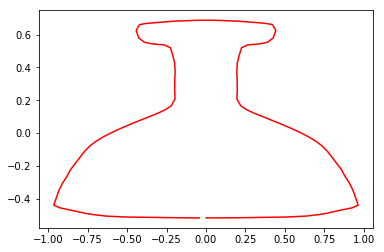

In [8]:
# Read in some pots
newpots = np.loadtxt('GoodPots/GoodPots_closed_procrustes.csv',delimiter=',')
npots = np.shape(newpots)[0]
npoints = np.shape(newpots)[1]//2
newpots = np.reshape(newpots,[npots,npoints,2])
pl.plot(newpots[227,:,0],newpots[227,:,1],'r')

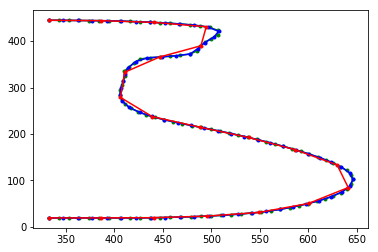

In [146]:
# This plot suggests that for mantamados data 50 points is sufficient for open curve, so 100 for closed (probably overkill)
# For good pots 70 points is sufficient for open curve, so 140 for closed (probably overkill)
index = 22
n100 = np.squeeze(resample(points[index:index+1,:,:],100))
n70 = np.squeeze(resample(points[index:index+1,:,:],70))
n20 = np.squeeze(resample(points[index:index+1,:,:],20))

pl.plot(n100[:,0],n100[:,1],'g.-');
pl.plot(n70[:,0],n70[:,1],'b.-');
pl.plot(n20[:,0],n20[:,1],'r.-');


In [373]:
# Read in the mantamados data (open curves)
df = pd.read_csv('mantamados_normandata_open_raw.csv')

maxpoints = max(df['pointorder']-10)
n = df.iloc[:,:3]

# Read points dat into points and names into filenames
id = n.iloc[0,0]
count = 0
pot = 0
filenames = []
filenames.append(id)
#print(id,pot)
# +1 in line below is so there is a 0 so that where() works
points = np.zeros((25,maxpoints+1,2))
for i in range(len(n)):
    if n.iloc[i,0] == id:
        points[pot,count,:] = n.iloc[i,1:3]
        count += 1
    else:
        id = n.iloc[i,0]
        count = 0
        pot += 1
        #print(id,pot)
        filenames.append(id)

In [12]:
# Save the mantamados pots
# So points holds all 25 pots in an (npots*npoints*2)
# Need to make 2D to save easily
pots = np.reshape(newpots,[npots,npoints*2])
np.savetxt('pots_open.csv', pots,delimiter=',')
# To put back after reloading
#pots = np.reshape(pots,[npots,npoints,2])

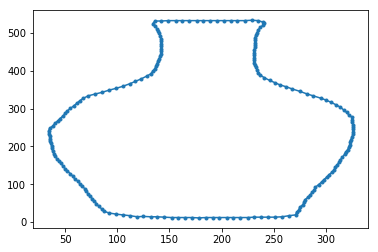

In [85]:
# Same for closed Mantamados pots. Note these have 'correct' point order!
npots = 25
df = pd.read_csv('mantamados_normandata_closed_raw.csv')
maxpoints = max(df['pointorder'])

n = df.iloc[:,:3]

id = n.iloc[0,0]
count = 0
pot = 0
# +1 in line below is so there is a 0 so that where() works
points = np.zeros((npots,maxpoints+1,2))
for i in range(len(n)):
    if n.iloc[i,0] == id:
        points[pot,count,:] = n.iloc[i,1:3]
        count += 1
    else:
        id = n.iloc[i,0]
        #print(id,count)
        count = 0
        pot += 1

# Resample
newpots = resample(points,100)

# Save
pots = np.reshape(newpots,[npots,npoints*2])
np.savetxt('pots_closed.csv', pots,delimiter=',')

pots = np.reshape(pots,[npots,npoints,2])
ind = np.max(np.where(points[0,:,0] != 0)[0])
pl.plot(points[0,:ind+1,0],points[0,:ind+1,1],'.-');

# Check that the saving worked
newpots = np.loadtxt('pots_closed_procrustes.csv',delimiter=',')

#pots = np.loadtxt('pots_open.csv',delimiter=',')
npots = np.shape(newpots)[0]
npoints = np.shape(newpots)[1]//2
newpots = np.reshape(newpots,[npots,npoints,2])


In [5]:
test = procrustes_align(newpots)
test[17,:,:]
pl.plot(test[228,:,0],test[228,:,1])

NameError: name 'newpots' is not defined

In [48]:
# Compute the Hausdorff disimilarity 
# Not very useful
from scipy.spatial.distance import directed_hausdorff
d = directed_hausdorff(pots[i,:,:],pots[j,:,:])
disparity2 = np.zeros((npots,npots))
disparity3 = np.zeros((npots,npots))
for i in range(npots-1):
    for j in range(i,npots):
        disparity2[i,j], _, _ = directed_hausdorff(pots[i,:,:],pots[j,:,:])
        disparity3[i,j], _, _ = directed_hausdorff(newpots[i,:,:],newpots[j,:,:])

pl.plot(disparity[0,:]/np.max(disparity[0,:]))
pl.plot(disparity2[0,:]/np.max(disparity2[0,:]))
pl.plot(disparity3[0,:]/np.max(disparity3[0,:]))

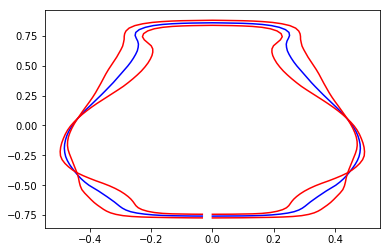

In [116]:
# Plot mean pot + some number of \pm standard deviations of some principal component
m, evals,evecs = asm('GoodPots/GoodPots_closed_procrustes.csv')
npoints = np.shape(pots)[1]//2
evecs = evecs.reshape((npoints,2,npoints*2))
sd = 1
pc = 2
pl.plot(m[:,0],m[:,1],'b')
pl.plot(m[:,0] - np.sqrt(evals[pc])*sd*evecs[:,0,pc],m[:,1] - np.sqrt(evals[pc])*sd*evecs[:,1,pc],'r') 
pl.plot(m[:,0] + np.sqrt(evals[pc])*sd*evecs[:,0,pc],m[:,1] + np.sqrt(evals[pc])*sd*evecs[:,1,pc],'r') 

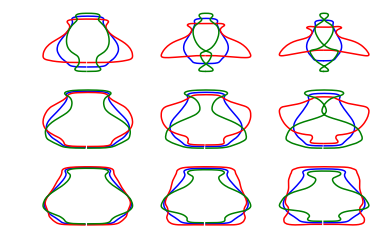

In [18]:
for pc in range(3):
    for sd in range(1,4):
        pl.subplot(3,3,pc*3+sd);
        pl.plot(m[:,0],m[:,1],'b')
        pl.plot(m[:,0] - np.sqrt(evals[pc])*sd*evecs[:,0,pc],m[:,1] - np.sqrt(evals[pc])*sd*evecs[:,1,pc],'r') 
        pl.plot(m[:,0] + np.sqrt(evals[pc])*sd*evecs[:,0,pc],m[:,1] + np.sqrt(evals[pc])*sd*evecs[:,1,pc],'g')         
        pl.axis('off')

In [79]:
#m, evals,evecs = asm('GoodPots/GoodPots_closed_procrustes.csv')
# Get each pot in PCA space
m = np.squeeze(m.reshape((276,1)))
ndim = 10
b = np.zeros((325,ndim))
for i in range(325):
    P = evecs[:,:ndim]
    b[i,:] = np.dot(P.T,(pots[i,:]-m))

Number of dims to use: 6
[0.7331355  0.86256454 0.91410523 0.94885906 0.96421344 0.9758998
 0.984314   0.98769494 0.99070983 0.99250607]


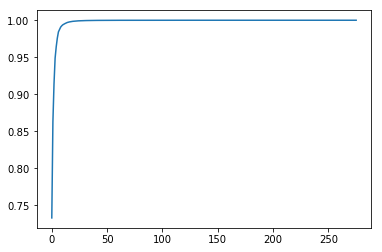

In [119]:
# Scree plot
cs = np.cumsum(evals)
cs /= cs[-1]
pl.plot(cs)
print("Number of dims to use:",np.where(cs>0.98*cs[-1])[0][0])
print(cs[:10])

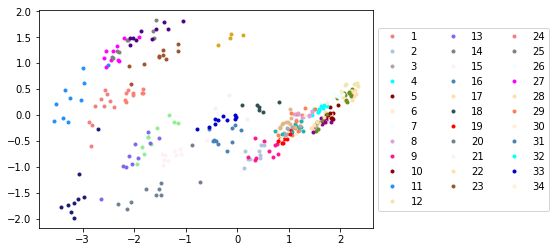

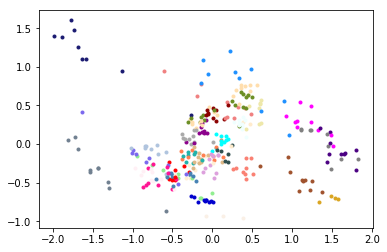

In [126]:
# Plots
for i in range(325):
    pl.plot(b[i,0],b[i,1],'.',color=c[4*a[i][2]])
pl.legend(np.unique(names),ncol=3,loc='center left', bbox_to_anchor=(1, 0.5))
pl.figure()
for i in range(325):
    pl.plot(b[i,1],b[i,2],'.',color=c[4*a[i][2]])

In [2]:
df = pd.read_csv('PC_RW_large_Mantamados_closed.csv')

In [ ]:
# These are 100 runs of 1000 timesteps each with 140 (x,y) coords
# So that's 1000 100x100 distance matrices! Might take a while...
